# Regression Example in TensorFlow

## Advanced topics on machine learning <br>

Mauricio A. Álvarez, PhD <br>
Cristian Guarnizo PhD, y Hernán F. García PhD (c) - TA

Jupyter notebook for the course of Bayesian Machine Learning, section: Introduction to Neural Networks. Universidad Tecnológica de Pereira. The following notebook is based from the ["Basic Regression"](https://www.tensorflow.org/tutorials/keras/basic_regression) from TensorFlow examples.

In this example we use TensorFlow 2.0 (TF2). If you already have this version of TF2 installed in your machine, you can skip this step. However, if your are running this code in a Google Colab session, the you need to excute this next line.

In [0]:
!pip install tensorflow==2.0.0-alpha0

Typically, we start by importing all the libraries that we require for this example

In [1]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


## Auto MPG Dataset

Next, we download the Auto MGP dataset from the UCI webpage by executing the following line.

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

We use Pandas library in order obtain a statistical description of this dataset. The description of this dataset can be found at [UCI_MGP_data_link](https://archive.ics.uci.edu/ml/datasets/auto+mpg). Thus, we define the names of the columns and read the values from the file we just downloaded.

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


We check if this data contain nan values. If so, we drop them. The following code line tell us how many entries are nan.

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

To keep this example simple we drop those rows by running the following code line.

In [0]:
dataset = dataset.dropna()

The column "Origin" uses an integer value to represent the Country where the car was built. We change this into "one-hot" representation for this example. Thus, we extract the Origin column and replace it with three new columns indicating each country.

In [6]:
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## Define train and test data

Now we split the data into train and test sets. The former is used 

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Now we take a look at the training data using a scatter plot where its diagonal is composed by the probabillity density estimated by kernel density estimation.

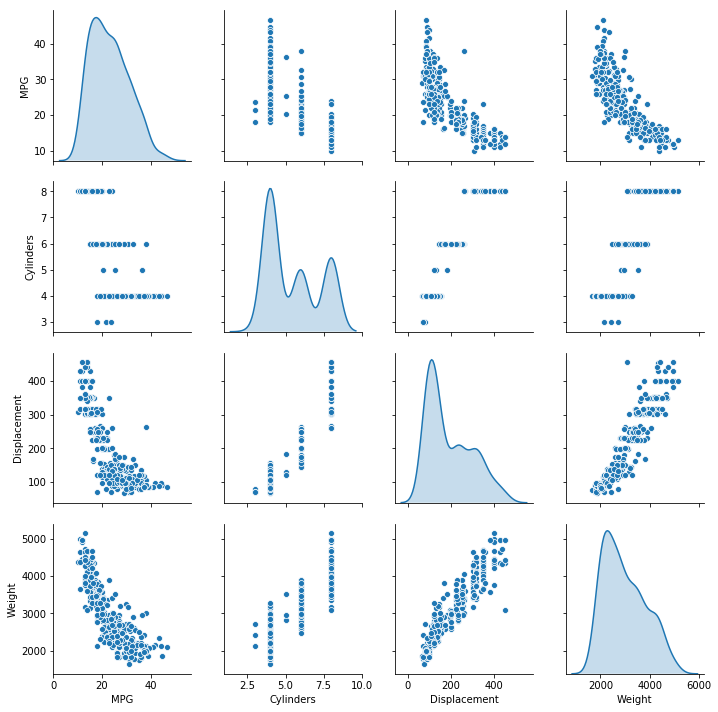

In [8]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

The variable that we are going to predict is MPG. Thus, we separate the label or target values from the attributes or inputs. 

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

Next, we analise some statistical values for the inputs.

In [10]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


As we can see, there are some variables that have a wide range of values. So, in order to avoid our model to be sensible to these large values, we normalize the train and test data.

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## The Neural Network Model

We build the NN model using the sequential constructor command from TensorFlow.

In [12]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


We can obtain a Summary of the model we've just defined using the following line

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### Questions
1. Why the number of weights for the first layer is 640?
2. What is the activation function for the output?

## Train the model

Now we proceed to learn the weights of the model defined above. We save the training performance by caching the model's accuracy in the history variabe.

In [14]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

Next, we define a function that allows us to see the Mean Absolute and Mean Square error along the epochs (training process).

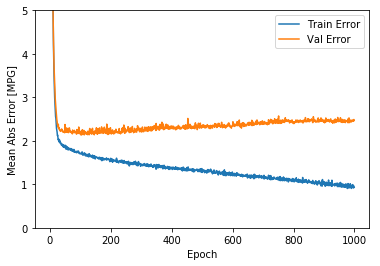

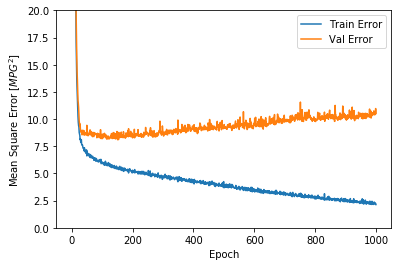

In [15]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

The above graphs show how the train error improves along the epochs. Howerever, the validation error starts to degradate after 200 epochs, which indicates that our model is overfitting. We are able to avoid this problem by using the regularization technique knows as Early stopping.
Let's put this in the model training procedure.


....................................................................................

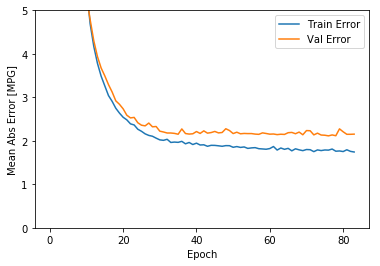

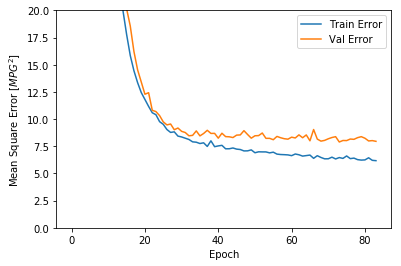

In [16]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

## Prediction step
Now we proceed to check our model ability to predict the test data.

In [17]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set Mean Square Error: {:5.2f} MPG".format(mse))

Testing set Mean Abs Error:  1.80 MPG
Testing set Mean Square Error:  5.42 MPG


Additionally, we can compare the predictions of our model with respect to the test values, like this:

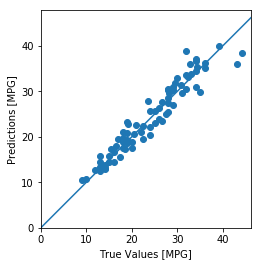

In [18]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

# Excercises

Try using a different neural network and compare its performance with the results obatined above: <br>
    a) Using different activation functions (tanh, sigmoid). <br>
    b) Using a different number of layers. <br>
    c) Using regularization over the weights of each layer (L2, with learning rate 0.01). <br> <br>

[Keras regularizators](https://medium.com/@robertjohn_15390/regularization-in-tensorflow-using-keras-api-48aba746ae21)